# Predict Future Values of Emissions

In [174]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras import backend as K

## Read Data

In [175]:
# Read in emission data
emission_input = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_input['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
emission_index = emission_input['date'].values
# Take only the emissions on which we have indicators
print(f"Shape output data: {emission_data.shape}")
#print(emission_index)


Shape output data: (372,)


In [176]:
data= pd.Series(emission_data)
first_date = emission_index[0]
last_date = emission_index[-1]
split_train = np.arange(0, len(data)-12)
split_test = np.arange((len(data)-12), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)
time_scope = emission_index

# Auto Sarima Model

In [177]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=717.429, BIC=736.690, Time=3.196 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1403.583, BIC=1411.288, Time=0.055 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=757.013, BIC=772.421, Time=1.463 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1070.896, BIC=1086.305, Time=1.389 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1475.419, BIC=1479.271, Time=0.047 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=945.975, BIC=961.384, Time=0.236 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=692.153, BIC=715.266, Time=5.160 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=758.887, BIC=778.148, Time=1.980 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=693.927, BIC=720.892, Time=11.056 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=693.922, BIC=720.887, Time=11.980 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  360
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -340.805
Date:                              Mon, 10 Aug 2020   AIC                            691.611
Time:                                      15:59:43   BIC                            710.872
Sample:                                           0   HQIC                           699.279
                                              - 360                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0451      0.029     -1.537      0.124      -0.103       0.012
ar.L1          0.9614      0.018     53.496      0.000       0.926       0.997
ar.S.L12      -0.3168      0.027    -11.572      0.000      -0.370      -0.263
ma.S.L12      -0.7309      0.033    -22.000      0.000      -0.796      -0.666
sigma2         0.3959      0.010     39.167      0.000       0.376       0.416
===================================================================================
Ljung-Box (Q):                       48.21   Jarque-Bera (JB):              8510.69
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

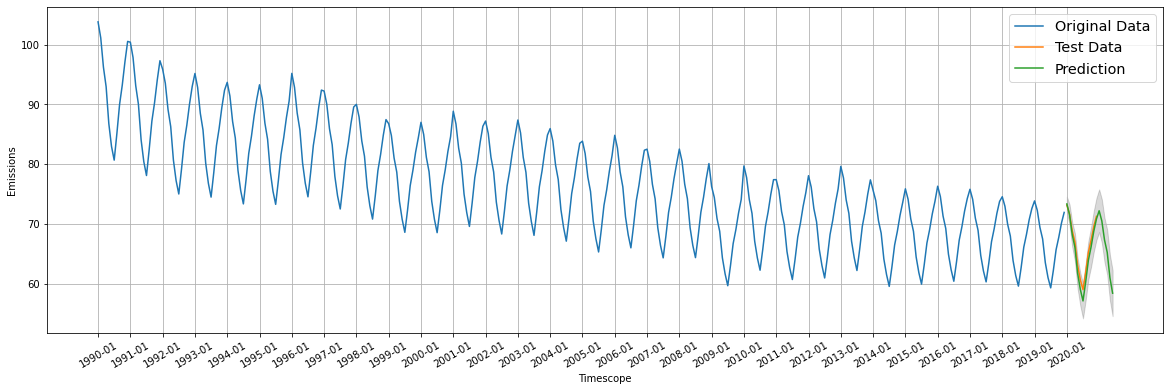

In [178]:
# Forecast
n_periods = 18
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)
index_of_test = np.arange(len(data)-12, len(data))

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
test_series = pd.Series(test_data, index=index_of_test)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Original Data')
line3 = plt.plot(test_series, label='Test Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope))[::12], time_scope[::12], rotation=30)
plt.xlabel("Timescope")
plt.ylabel("Emissions")
plt.show()

In [179]:
# Accuracy metrics
fitted = fitted[0:12]
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print("Accuracy of the model:")
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fitted, test_data)

Accuracy of the model:


{'mape': 0.015680226744539144,
 'me': -0.971294580111684,
 'mae': 1.0032270846786062,
 'mpe': -0.015243802350923963,
 'rmse': 1.1473169143791413,
 'corr': 0.9994502216264892,
 'minmax': 0.015679656838111455}

## MLP Model

In [180]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [181]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [182]:
scaler = StandardScaler()
#emission_data = scaler.fit_transform(emission_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(emission_data) * split_ratio)
test_size = len(emission_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

In [183]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [184]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [185]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(279, 12)
(279, 6)
(57, 12)
(57, 6)


### Train Model

In [186]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/100
140/140 - 0s - loss: 1391.2242
Epoch 2/100
140/140 - 0s - loss: 50.1995
Epoch 3/100
140/140 - 0s - loss: 45.3526
Epoch 4/100
140/140 - 0s - loss: 39.6304
Epoch 5/100
140/140 - 0s - loss: 36.4572
Epoch 6/100
140/140 - 0s - loss: 31.8801
Epoch 7/100
140/140 - 0s - loss: 29.8774
Epoch 8/100
140/140 - 0s - loss: 28.0130
Epoch 9/100
140/140 - 0s - loss: 24.2165
Epoch 10/100
140/140 - 0s - loss: 22.9321
Epoch 11/100
140/140 - 0s - loss: 19.9667
Epoch 12/100
140/140 - 0s - loss: 17.3882
Epoch 13/100
140/140 - 0s - loss: 16.3083
Epoch 14/100
140/140 - 0s - loss: 14.3692
Epoch 15/100
140/140 - 0s - loss: 12.9405
Epoch 16/100
140/140 - 0s - loss: 10.8056
Epoch 17/100
140/140 - 0s - loss: 9.5499
Epoch 18/100
140/140 - 0s - loss: 8.4727
Epoch 19/100
140/140 - 0s - loss: 7.8605
Epoch 20/100
140/140 - 0s - loss: 8.0432
Epoch 21/100
140/140 - 0s - loss: 7.1352
Epoch 22/100
140/140 - 0s - loss: 6.6490
Epoch 23/100
140/140 - 0s - loss: 7.4422
Epoch 24/100
140/140 - 0s - loss: 6.9208
Epoch 2

140/140 - 0s - loss: 6.1479
Epoch 53/100
140/140 - 0s - loss: 5.1257
Epoch 54/100
140/140 - 0s - loss: 5.4062
Epoch 55/100
140/140 - 0s - loss: 4.8632
Epoch 56/100
140/140 - 0s - loss: 4.8295
Epoch 57/100
140/140 - 0s - loss: 4.8957
Epoch 58/100
140/140 - 0s - loss: 4.8035
Epoch 59/100
140/140 - 0s - loss: 5.3259
Epoch 60/100
140/140 - 0s - loss: 4.7981
Epoch 61/100
140/140 - 0s - loss: 5.4119
Epoch 62/100
140/140 - 0s - loss: 5.4308
Epoch 63/100
140/140 - 0s - loss: 5.3786
Epoch 64/100
140/140 - 0s - loss: 5.4071
Epoch 65/100
140/140 - 0s - loss: 4.9055
Epoch 66/100
140/140 - 0s - loss: 4.8449
Epoch 67/100
140/140 - 0s - loss: 4.7505
Epoch 68/100
140/140 - 0s - loss: 4.6542
Epoch 69/100
140/140 - 0s - loss: 5.5614
Epoch 70/100
140/140 - 0s - loss: 4.8166
Epoch 71/100
140/140 - 0s - loss: 5.7977
Epoch 72/100
140/140 - 0s - loss: 4.5238
Epoch 73/100
140/140 - 0s - loss: 4.9416
Epoch 74/100
140/140 - 0s - loss: 4.4835
Epoch 75/100
140/140 - 0s - loss: 5.4595
Epoch 76/100
140/140 - 0s - l

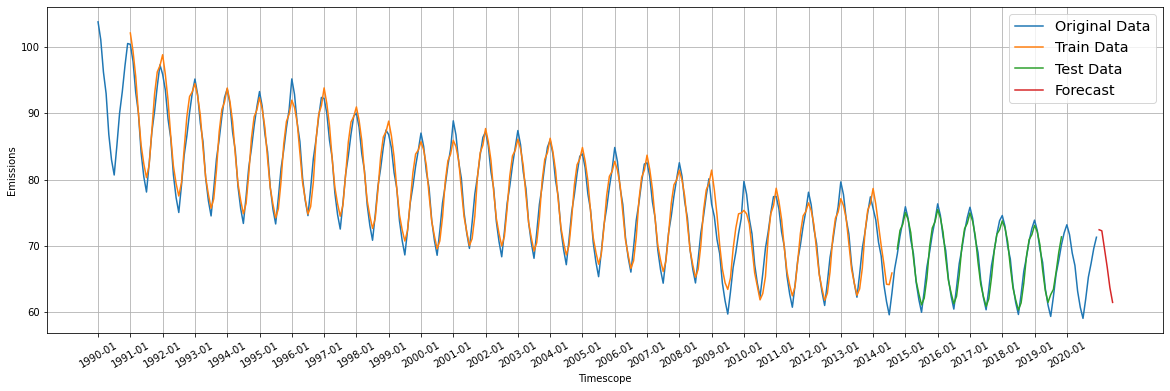

In [187]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='Original Data')
line3 = plt.plot(trainPredictPlot[:], label='Train Data')
line2 = plt.plot(testPredictPlot[:], label='Test Data')
line4 = plt.plot(forecastPlot[:], label='Forecast')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope))[::12], time_scope[::12], rotation=30)
plt.xlabel("Timescope")
plt.ylabel("Emissions")
plt.show()

## Compare SARIMA with MLP

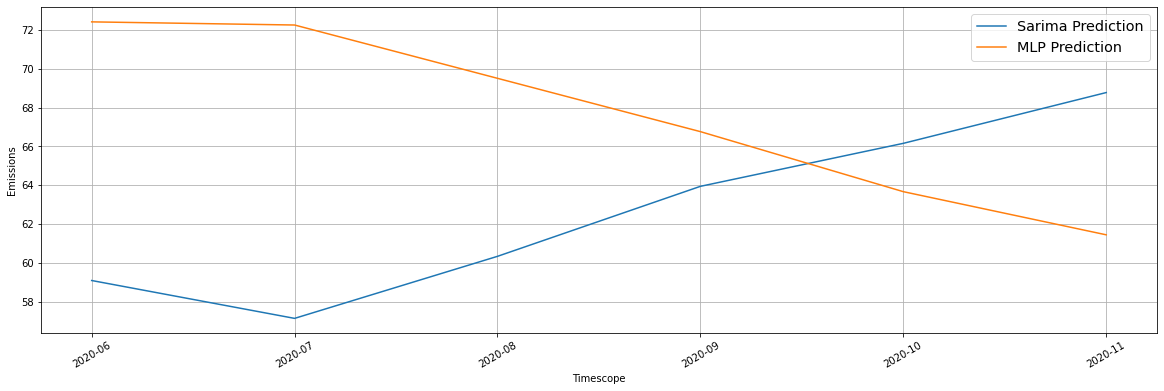

In [214]:
sarima_plot = fitted[-7:-1]
mlp_plot[0:horizon] = predict[:]
#sarima_plot = fitted_series[-7:-1] 


#plot difference between the forecasts
plt.figure(figsize=(20,6))
line1 = plt.plot(sarima_plot, label='Sarima Prediction')
line2 = plt.plot(mlp_plot, label='MLP Prediction')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(6), ['2020-06','2020-07', '2020-08', '2020-09', '2020-10', '2020-11'], rotation=30)
plt.xticks()
plt.xlabel("Timescope")
plt.ylabel("Emissions")
plt.show()


In [189]:
#compare the accuracy of prediction of the previous year


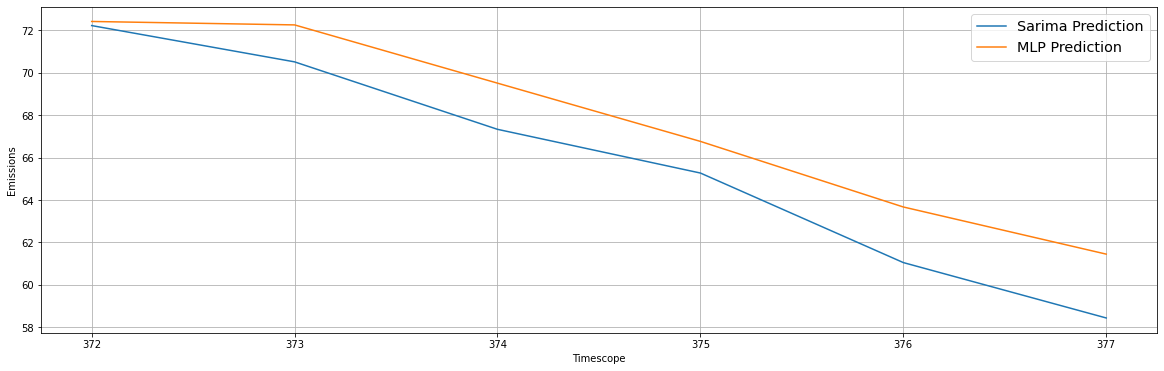

['2020-06' '2020-07' '2020-08' '2020-09' '2020-10' '2020-11']


In [198]:
time_scope_short = time_scope[-7:-1]



plt.figure(figsize=(20,6))


line1 = plt.plot(fitted_series.tail(6), label='Sarima Prediction')
line2 = plt.plot(forecastPlot[:], label='MLP Prediction')

plt.legend(fontsize='x-large')
plt.grid()
#plt.xticks(np.arange(6), ['2020-06','2020-07', '2020-08', '2020-09', '2020-10', '2020-11'], rotation=30)
plt.xlabel("Timescope")
plt.ylabel("Emissions")
plt.show()
print(time_scope_short)